# Testing of VGG19 on the brain MRI Dataset

__Authors: Dibyasundar Das, Deepak Ranjan Nayak__

__Version: 1.0.0__

__Last Modification Date: 10 May 2020__

__Last Modified By: Dibyasundar Das__

## Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Impoting all necessary packages

In [2]:
import numpy as np
from keras.applications import VGG19
from keras.layers import Dense
from keras.models import Model
from keras.utils import to_categorical
import keras.optimizers as optimizers
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import time
import gc

Using TensorFlow backend.


## Reading the dataset, lebels and folds

In [0]:
data_set = np.load('/content/drive/My Drive/Colab/check.npy',allow_pickle=True)
data_set = data_set.item()

In [0]:
images = data_set['image']
labels = np.array(data_set['label'])-1
fold_id = data_set['fold']

In [5]:
# verifying the shape
print(images.shape)
print(labels.shape)
print(fold_id.shape)

(3064, 224, 224)
(3064,)
(3064,)


## Modifying the dataset shape

In [0]:
images = np.expand_dims(images, axis=3) * 255
images = np.repeat(images, 3, axis=3)

In [7]:
# verifying the shape
print(images.shape)
print(labels.shape)
print(fold_id.shape)

(3064, 224, 224, 3)
(3064,)
(3064,)


## Reading the model and verifying the shape of input

In [0]:
model=VGG19(include_top=True, weights='imagenet')

In [9]:
model.layers[0].output_shape

(None, 224, 224, 3)

## Get structure of model

In [10]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Define a function to create a new model

In [0]:
def new_vgg_19_transfer(model):
    out = model.layers[-2]
    out=Dense(3,activation='softmax', name='prediction')(out.output)
    new_model=Model(inputs=model.input,outputs=out, name='Modified VGG 19 model for brain MRI')
    for i in range(len(new_model.layers)):
        new_model.layers[i].trainable = False
    new_model.layers[-1].trainable = True
    return new_model

## Testing structure of new model

In [12]:
new_model=new_vgg_19_transfer(model)
new_model.summary()

Model: "Modified VGG 19 model for brain MRI"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (N

## Testing if the respective weights are loaded

In [13]:
for i in range(len(model.layers)):
    if model.layers[i].weights == new_model.layers[i].weights:
        print(model.layers[i].name + '   :   ' + str(1))
    else:
        print(model.layers[i].name + '   :   ' + str(0))

input_1   :   1
block1_conv1   :   1
block1_conv2   :   1
block1_pool   :   1
block2_conv1   :   1
block2_conv2   :   1
block2_pool   :   1
block3_conv1   :   1
block3_conv2   :   1
block3_conv3   :   1
block3_conv4   :   1
block3_pool   :   1
block4_conv1   :   1
block4_conv2   :   1
block4_conv3   :   1
block4_conv4   :   1
block4_pool   :   1
block5_conv1   :   1
block5_conv2   :   1
block5_conv3   :   1
block5_conv4   :   1
block5_pool   :   1
flatten   :   1
fc1   :   1
fc2   :   1
predictions   :   0


## Define a function for fold devision

In [0]:
def fold_devide_train_test(images, labels, fold_id, current_id):
    train_images = images[fold_id != current_id,:,:,:]
    train_label = labels[fold_id != current_id]
    test_images = images[fold_id == current_id,:,:,:]
    test_label = labels[fold_id == current_id]
    return train_images, train_label, test_images, test_label

## Traing and testing code

In [15]:
batch=20
epoch=50
fold_wise_train_time=[]
fold_wise_test_time=[]
fold_wise_history=[]
fold_wise_confusion=[]
fold_wise_accuracy=[]
for current_id in np.arange(1,6,1):
    train_images, train_label, test_images, test_label = fold_devide_train_test(images, labels, fold_id, current_id)
    new_model = new_model=new_vgg_19_transfer(model)
    new_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001,  decay=0.00005), loss='mse', metrics=['accuracy'])
    train_label_cat = to_categorical(train_label)
    start=time.time()
    hist = new_model.fit(train_images,train_label_cat, batch_size=batch, epochs=epoch )
    end=time.time()
    fold_wise_train_time.append(end-start)
    start=time.time()
    prediction_prob = new_model.predict(test_images, batch_size=batch)
    end=time.time()
    fold_wise_test_time.append(end-start)
    obt_test_label = np.argmax(prediction_prob,1)
    fold_wise_accuracy.append(accuracy_score(test_label,obt_test_label))
    print(accuracy_score(test_label,obt_test_label))
    fold_wise_confusion.append(confusion_matrix(test_label,obt_test_label))
    fold_wise_history.append(hist.history)
    del([train_images, train_label, test_images, test_label])
    gc.collect()

Epoch 1/50
2522/2522 [==============================] - 18s 7ms/step - loss: 0.1645 - accuracy: 0.6416
Epoch 2/50
2522/2522 [==============================] - 11s 4ms/step - loss: 0.1032 - accuracy: 0.7815
Epoch 3/50
2522/2522 [==============================] - 11s 4ms/step - loss: 0.0880 - accuracy: 0.8144
Epoch 4/50
2522/2522 [==============================] - 11s 4ms/step - loss: 0.0805 - accuracy: 0.8307
Epoch 5/50
2522/2522 [==============================] - 11s 4ms/step - loss: 0.0726 - accuracy: 0.8469
Epoch 6/50
2522/2522 [==============================] - 11s 4ms/step - loss: 0.0689 - accuracy: 0.8573
Epoch 7/50
2522/2522 [==============================] - 11s 4ms/step - loss: 0.0648 - accuracy: 0.8668
Epoch 8/50
2522/2522 [==============================] - 11s 4ms/step - loss: 0.0628 - accuracy: 0.8751
Epoch 9/50
2522/2522 [==============================] - 11s 4ms/step - loss: 0.0583 - accuracy: 0.8898
Epoch 10/50
2522/2522 [==============================] - 11s 4ms/step - l

=========================   FOLD WISE RESULT ========================================
=========================   FOLD 1 RESULT ========================================
Training Time : 547.0469746589661
Testing Time : 2.3598039150238037
accuracy : 0.8708487084870848
confusion matrix :
[[ 94  16   2]
 [ 24 221   0]
 [ 23   5 157]]
accuracy convergence


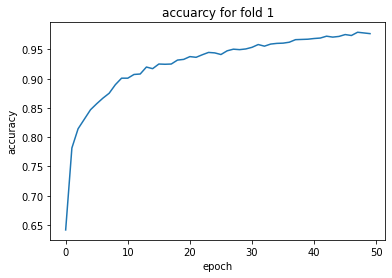

loss convergence


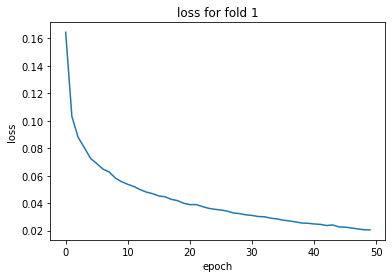

=========================   FOLD 2 RESULT ========================================
Training Time : 510.9987986087799
Testing Time : 3.4342427253723145
accuracy : 0.8159057437407953
confusion matrix :
[[ 92  61  14]
 [ 27 306   5]
 [ 13   5 156]]
accuracy convergence


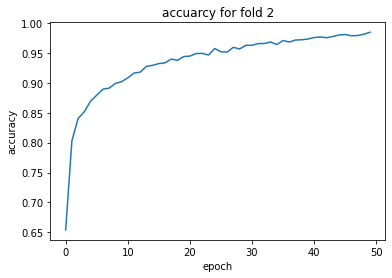

loss convergence


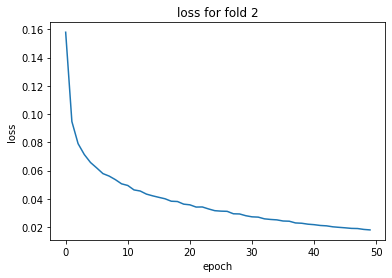

=========================   FOLD 3 RESULT ========================================
Training Time : 526.127002954483
Testing Time : 2.4468657970428467
accuracy : 0.8321678321678322
confusion matrix :
[[ 91  45   3]
 [ 38 190   3]
 [  1   6 195]]
accuracy convergence


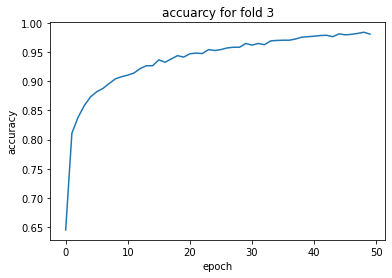

loss convergence


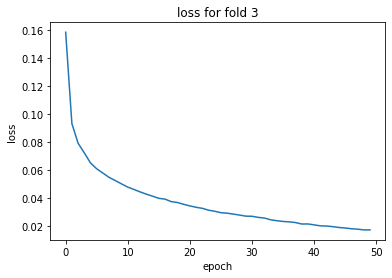

=========================   FOLD 4 RESULT ========================================
Training Time : 513.811342716217
Testing Time : 2.962141990661621
accuracy : 0.8757961783439491
confusion matrix :
[[ 96  19   9]
 [ 30 290   5]
 [  8   7 164]]
accuracy convergence


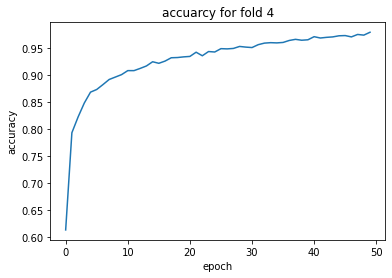

loss convergence


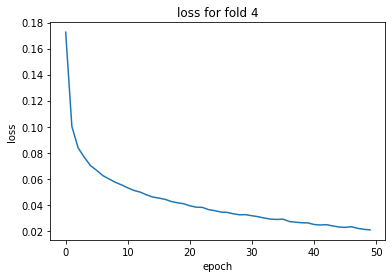

=========================   FOLD 5 RESULT ========================================
Training Time : 512.1959743499756
Testing Time : 2.9559452533721924
accuracy : 0.8227060653188181
confusion matrix :
[[ 98  39  29]
 [ 36 251   0]
 [  5   5 180]]
accuracy convergence


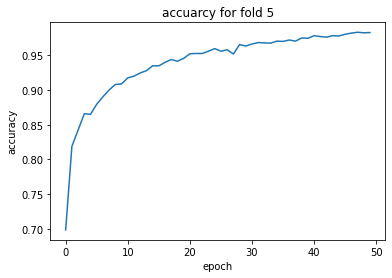

loss convergence


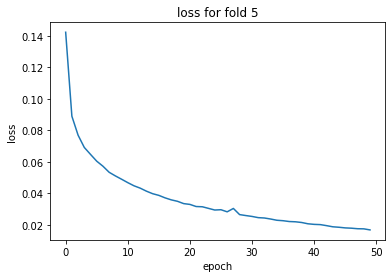

In [16]:
print('=====================================================================================')
print('=========================   FOLD WISE RESULT ========================================')
print('=====================================================================================')
for i in range(5):
  print('=========================   FOLD ' + str(i+1) + ' RESULT ========================================')
  print('Training Time : ' + str(fold_wise_train_time[i]))
  print('Testing Time : ' + str(fold_wise_test_time[i]))
  print('accuracy : ' + str(fold_wise_accuracy[i]))
  print('confusion matrix :')
  print(fold_wise_confusion[i])
  print('accuracy convergence')
  plt.plot(fold_wise_history[i]['accuracy'])
  plt.title('accuarcy for fold ' + str(i+1))
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.show()
  print('loss convergence')
  plt.plot(fold_wise_history[i]['loss'])
  plt.title('loss for fold ' + str(i+1))
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()